<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/10_IMPALA/10_IMPALA_RLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPALA with RLlib

이번 노트북에서는 RLlib에 구현된 IMPALA 알고리즘을 따라가며 RLlib으로 Policy와 Trainer를 어떻게 구현하는지 살펴보도록 하겠습니다.

이 노트북에서 사용하는 코드는 [RLlib IMPALA 구현코드](https://github.com/ray-project/ray/tree/master/rllib/agents/impala)에서 확인할 수 있습니다.

In [1]:
!pip install ray
!pip install ray[rllib]

In [2]:
import ray
import gym
import logging
import numpy as np

from ray.tune.trainable import Trainable
from ray.tune.utils.placement_groups import PlacementGroupFactory
from ray.rllib.utils import force_list
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.utils.torch_ops import convert_to_torch_tensor, \
    apply_grad_clipping, explained_variance, global_norm, sequence_mask
from ray.rllib.utils.annotations import override
from ray.rllib.agents.impala.vtrace_tf import VTraceFromLogitsReturns, VTraceReturns
from ray.rllib.agents.trainer import Trainer, with_common_config
from ray.rllib.agents.trainer_template import build_trainer
from ray.rllib.models.torch.torch_action_dist import TorchCategorical
from ray.rllib.policy.policy_template import build_policy_class
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.policy.torch_policy import LearningRateSchedule, \
    EntropyCoeffSchedule
from ray.rllib.execution.learner_thread import LearnerThread
from ray.rllib.execution.multi_gpu_learner import TFMultiGPULearner
from ray.rllib.execution.tree_agg import gather_experiences_tree_aggregation
from ray.rllib.execution.common import STEPS_TRAINED_COUNTER, \
    _get_global_vars, _get_shared_metrics
from ray.rllib.execution.replay_ops import MixInReplay
from ray.rllib.execution.rollout_ops import ParallelRollouts, ConcatBatches
from ray.rllib.execution.concurrency_ops import Concurrently, Enqueue, Dequeue
from ray.rllib.execution.metric_ops import StandardMetricsReporting

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# yapf: disable
# __sphinx_doc_begin__
DEFAULT_CONFIG = with_common_config({
    # V-trace params (see vtrace_tf/torch.py).
    "vtrace": True,
    "vtrace_clip_rho_threshold": 1.0,
    "vtrace_clip_pg_rho_threshold": 1.0,
    # System params.
    #
    # == Overview of data flow in IMPALA ==
    # 1. Policy evaluation in parallel across `num_workers` actors produces
    #    batches of size `rollout_fragment_length * num_envs_per_worker`.
    # 2. If enabled, the replay buffer stores and produces batches of size
    #    `rollout_fragment_length * num_envs_per_worker`.
    # 3. If enabled, the minibatch ring buffer stores and replays batches of
    #    size `train_batch_size` up to `num_sgd_iter` times per batch.
    # 4. The learner thread executes data parallel SGD across `num_gpus` GPUs
    #    on batches of size `train_batch_size`.
    #
    "rollout_fragment_length": 50,
    "train_batch_size": 500,
    "min_iter_time_s": 10,
    "num_workers": 2,
    # number of GPUs the learner should use.
    "num_gpus": 1,
    # set >1 to load data into GPUs in parallel. Increases GPU memory usage
    # proportionally with the number of buffers.
    "num_data_loader_buffers": 1,
    # how many train batches should be retained for minibatching. This conf
    # only has an effect if `num_sgd_iter > 1`.
    "minibatch_buffer_size": 1,
    # number of passes to make over each train batch
    "num_sgd_iter": 1,
    # set >0 to enable experience replay. Saved samples will be replayed with
    # a p:1 proportion to new data samples.
    "replay_proportion": 0.0,
    # number of sample batches to store for replay. The number of transitions
    # saved total will be (replay_buffer_num_slots * rollout_fragment_length).
    "replay_buffer_num_slots": 0,
    # max queue size for train batches feeding into the learner
    "learner_queue_size": 16,
    # wait for train batches to be available in minibatch buffer queue
    # this many seconds. This may need to be increased e.g. when training
    # with a slow environment
    "learner_queue_timeout": 300,
    # level of queuing for sampling.
    "max_sample_requests_in_flight_per_worker": 2,
    # max number of workers to broadcast one set of weights to
    "broadcast_interval": 1,
    # Use n (`num_aggregation_workers`) extra Actors for multi-level
    # aggregation of the data produced by the m RolloutWorkers
    # (`num_workers`). Note that n should be much smaller than m.
    # This can make sense if ingesting >2GB/s of samples, or if
    # the data requires decompression.
    "num_aggregation_workers": 0,

    # Learning params.
    "grad_clip": 40.0,
    # either "adam" or "rmsprop"
    "opt_type": "adam",
    "lr": 0.0005,
    "lr_schedule": None,
    # rmsprop considered
    "decay": 0.99,
    "momentum": 0.0,
    "epsilon": 0.1,
    # balancing the three losses
    "vf_loss_coeff": 0.5,
    "entropy_coeff": 0.01,
    "entropy_coeff_schedule": None,

    "framework": "torch",

    # Callback for APPO to use to update KL, target network periodically.
    # The input to the callback is the learner fetches dict.
    "after_train_step": None,
})
# __sphinx_doc_end__
# yapf: enable

# V-trace

IMPALA에서 가장 핵심이 되는 V-trace 개념을 이용해 value function의 target과 policy의 advantage를 구하는 부분입니다.

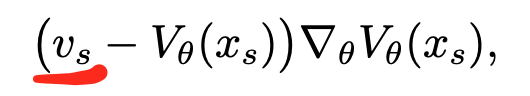

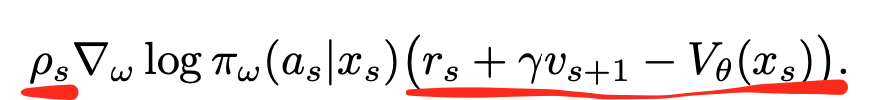

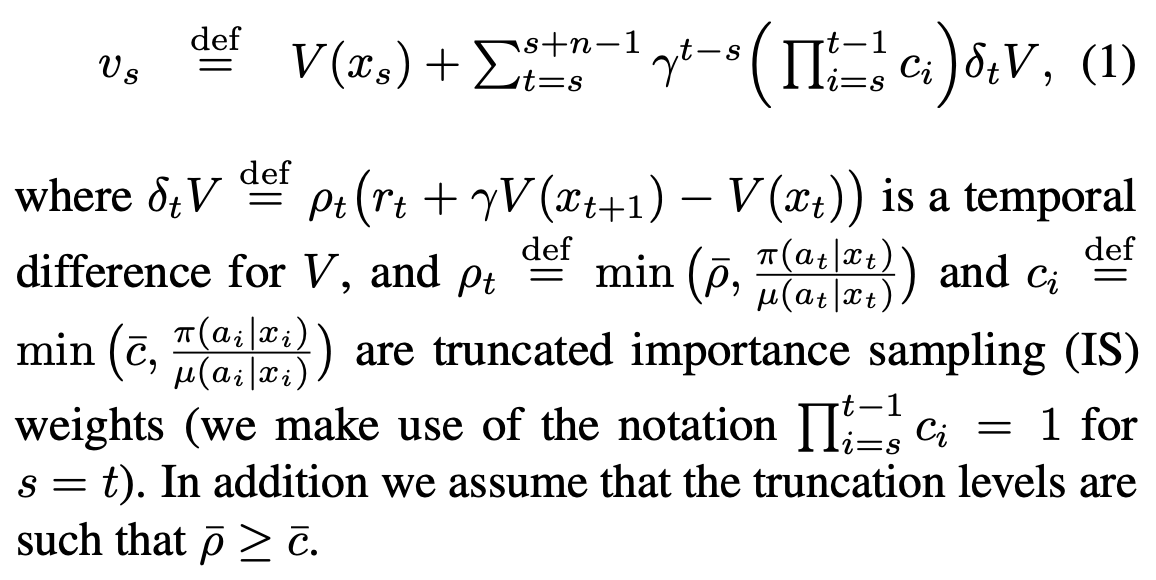

In [5]:
def from_importance_weights(log_rhos,
                            discounts,
                            rewards,
                            values,
                            bootstrap_value,
                            clip_rho_threshold=1.0,
                            clip_pg_rho_threshold=1.0):
    """V-trace from log importance weights.
    Calculates V-trace actor critic targets as described in
    "IMPALA: Scalable Distributed Deep-RL with
    Importance Weighted Actor-Learner Architectures"
    by Espeholt, Soyer, Munos et al.
    In the notation used throughout documentation and comments, T refers to the
    time dimension ranging from 0 to T-1. B refers to the batch size. This code
    also supports the case where all tensors have the same number of additional
    dimensions, e.g., `rewards` is [T, B, C], `values` is [T, B, C],
    `bootstrap_value` is [B, C].
    Args:
        log_rhos: A float32 tensor of shape [T, B] representing the log
            importance sampling weights, i.e.
            log(target_policy(a) / behaviour_policy(a)). V-trace performs
            operations on rhos in log-space for numerical stability.
        discounts: A float32 tensor of shape [T, B] with discounts encountered
            when following the behaviour policy.
        rewards: A float32 tensor of shape [T, B] containing rewards generated
            by following the behaviour policy.
        values: A float32 tensor of shape [T, B] with the value function
            estimates wrt. the target policy.
        bootstrap_value: A float32 of shape [B] with the value function
            estimate at time T.
        clip_rho_threshold: A scalar float32 tensor with the clipping threshold
            for importance weights (rho) when calculating the baseline targets
            (vs). rho^bar in the paper. If None, no clipping is applied.
        clip_pg_rho_threshold: A scalar float32 tensor with the clipping
            threshold on rho_s in
            \rho_s \delta log \pi(a|x) (r + \gamma v_{s+1} - V(x_s)).
            If None, no clipping is applied.
    Returns:
        A VTraceReturns namedtuple (vs, pg_advantages) where:
        vs: A float32 tensor of shape [T, B]. Can be used as target to
            train a baseline (V(x_t) - vs_t)^2.
        pg_advantages: A float32 tensor of shape [T, B]. Can be used as the
            advantage in the calculation of policy gradients.
    """
    log_rhos = convert_to_torch_tensor(log_rhos, device="cpu")
    discounts = convert_to_torch_tensor(discounts, device="cpu")
    rewards = convert_to_torch_tensor(rewards, device="cpu")
    values = convert_to_torch_tensor(values, device="cpu")
    bootstrap_value = convert_to_torch_tensor(bootstrap_value, device="cpu")

    # Make sure tensor ranks are consistent.
    rho_rank = len(log_rhos.size())  # Usually 2.
    assert rho_rank == len(values.size())
    assert rho_rank - 1 == len(bootstrap_value.size()),\
        "must have rank {}".format(rho_rank - 1)
    assert rho_rank == len(discounts.size())
    assert rho_rank == len(rewards.size())

    rhos = torch.exp(log_rhos)
    if clip_rho_threshold is not None:
        clipped_rhos = torch.clamp_max(rhos, clip_rho_threshold)
    else:
        clipped_rhos = rhos

    cs = torch.clamp_max(rhos, 1.0)
    # Append bootstrapped value to get [v1, ..., v_t+1]
    values_t_plus_1 = torch.cat(
        [values[1:], torch.unsqueeze(bootstrap_value, 0)], dim=0)
    deltas = clipped_rhos * (rewards + discounts * values_t_plus_1 - values)

    vs_minus_v_xs = [torch.zeros_like(bootstrap_value)]
    for i in reversed(range(len(discounts))):
        discount_t, c_t, delta_t = discounts[i], cs[i], deltas[i]
        vs_minus_v_xs.append(delta_t + discount_t * c_t * vs_minus_v_xs[-1])
    vs_minus_v_xs = torch.stack(vs_minus_v_xs[1:])
    # Reverse the results back to original order.
    vs_minus_v_xs = torch.flip(vs_minus_v_xs, dims=[0])
    # Add V(x_s) to get v_s.
    vs = vs_minus_v_xs + values

    # Advantage for policy gradient.
    vs_t_plus_1 = torch.cat(
        [vs[1:], torch.unsqueeze(bootstrap_value, 0)], dim=0)
    if clip_pg_rho_threshold is not None:
        clipped_pg_rhos = torch.clamp_max(rhos, clip_pg_rho_threshold)
    else:
        clipped_pg_rhos = rhos
    pg_advantages = (
        clipped_pg_rhos * (rewards + discounts * vs_t_plus_1 - values))

    # Make sure no gradients backpropagated through the returned values.
    return VTraceReturns(vs=vs.detach(), pg_advantages=pg_advantages.detach())


importance sampling을 이용하는 부분입니다.

get_log_rhos함수에서
현재 업데이트 시키고있는 target policy의 action의 log prob과,
각 워커들이 사용했었던 behaviour policy의 action의 log prob을
빼주어 반환하게 됩니다. 이 반환된 값은 위에서 살펴보았던 from_importance_weights() 함수에서 exponential을 취하여 사용하게 됩니다.

In [6]:
def get_log_rhos(target_action_log_probs, behaviour_action_log_probs):
    """With the selected log_probs for multi-discrete actions of behavior
    and target policies we compute the log_rhos for calculating the vtrace."""
    t = torch.stack(target_action_log_probs)
    b = torch.stack(behaviour_action_log_probs)
    log_rhos = torch.sum(t - b, dim=0)
    return log_rhos

In [7]:
"""PyTorch version of the functions to compute V-trace off-policy actor critic
targets.
For details and theory see:
"IMPALA: Scalable Distributed Deep-RL with
Importance Weighted Actor-Learner Architectures"
by Espeholt, Soyer, Munos et al.
See https://arxiv.org/abs/1802.01561 for the full paper.
In addition to the original paper's code, changes have been made
to support MultiDiscrete action spaces. behaviour_policy_logits,
target_policy_logits and actions parameters in the entry point
multi_from_logits method accepts lists of tensors instead of just
tensors.
"""

torch, nn = try_import_torch()


def log_probs_from_logits_and_actions(policy_logits,
                                      actions,
                                      dist_class=TorchCategorical,
                                      model=None):
    return multi_log_probs_from_logits_and_actions([policy_logits], [actions],
                                                   dist_class, model)[0]


def multi_log_probs_from_logits_and_actions(policy_logits, actions, dist_class,
                                            model):
    """Computes action log-probs from policy logits and actions.
    In the notation used throughout documentation and comments, T refers to the
    time dimension ranging from 0 to T-1. B refers to the batch size and
    ACTION_SPACE refers to the list of numbers each representing a number of
    actions.
    Args:
        policy_logits: A list with length of ACTION_SPACE of float32
            tensors of shapes [T, B, ACTION_SPACE[0]], ...,
            [T, B, ACTION_SPACE[-1]] with un-normalized log-probabilities
            parameterizing a softmax policy.
        actions: A list with length of ACTION_SPACE of tensors of shapes
            [T, B, ...], ..., [T, B, ...]
            with actions.
        dist_class: Python class of the action distribution.
    Returns:
        A list with length of ACTION_SPACE of float32 tensors of shapes
            [T, B], ..., [T, B] corresponding to the sampling log probability
            of the chosen action w.r.t. the policy.
    """
    log_probs = []
    for i in range(len(policy_logits)):
        p_shape = policy_logits[i].shape
        a_shape = actions[i].shape
        policy_logits_flat = torch.reshape(policy_logits[i],
                                           (-1, ) + tuple(p_shape[2:]))
        actions_flat = torch.reshape(actions[i], (-1, ) + tuple(a_shape[2:]))
        log_probs.append(
            torch.reshape(
                dist_class(policy_logits_flat, model).logp(actions_flat),
                a_shape[:2]))

    return log_probs


def from_logits(behaviour_policy_logits,
                target_policy_logits,
                actions,
                discounts,
                rewards,
                values,
                bootstrap_value,
                dist_class=TorchCategorical,
                model=None,
                clip_rho_threshold=1.0,
                clip_pg_rho_threshold=1.0):
    """multi_from_logits wrapper used only for tests"""

    res = multi_from_logits(
        [behaviour_policy_logits], [target_policy_logits], [actions],
        discounts,
        rewards,
        values,
        bootstrap_value,
        dist_class,
        model,
        clip_rho_threshold=clip_rho_threshold,
        clip_pg_rho_threshold=clip_pg_rho_threshold)

    assert len(res.behaviour_action_log_probs) == 1
    assert len(res.target_action_log_probs) == 1
    return VTraceFromLogitsReturns(
        vs=res.vs,
        pg_advantages=res.pg_advantages,
        log_rhos=res.log_rhos,
        behaviour_action_log_probs=res.behaviour_action_log_probs[0],
        target_action_log_probs=res.target_action_log_probs[0],
    )


def multi_from_logits(behaviour_policy_logits,
                      target_policy_logits,
                      actions,
                      discounts,
                      rewards,
                      values,
                      bootstrap_value,
                      dist_class,
                      model,
                      behaviour_action_log_probs=None,
                      clip_rho_threshold=1.0,
                      clip_pg_rho_threshold=1.0):
    """V-trace for softmax policies.
    Calculates V-trace actor critic targets for softmax polices as described in
    "IMPALA: Scalable Distributed Deep-RL with
    Importance Weighted Actor-Learner Architectures"
    by Espeholt, Soyer, Munos et al.
    Target policy refers to the policy we are interested in improving and
    behaviour policy refers to the policy that generated the given
    rewards and actions.
    In the notation used throughout documentation and comments, T refers to the
    time dimension ranging from 0 to T-1. B refers to the batch size and
    ACTION_SPACE refers to the list of numbers each representing a number of
    actions.
    Args:
        behaviour_policy_logits: A list with length of ACTION_SPACE of float32
            tensors of shapes [T, B, ACTION_SPACE[0]], ...,
            [T, B, ACTION_SPACE[-1]] with un-normalized log-probabilities
            parameterizing the softmax behavior policy.
        target_policy_logits: A list with length of ACTION_SPACE of float32
            tensors of shapes [T, B, ACTION_SPACE[0]], ...,
            [T, B, ACTION_SPACE[-1]] with un-normalized log-probabilities
            parameterizing the softmax target policy.
        actions: A list with length of ACTION_SPACE of tensors of shapes
            [T, B, ...], ..., [T, B, ...]
            with actions sampled from the behavior policy.
        discounts: A float32 tensor of shape [T, B] with the discount
            encountered when following the behavior policy.
        rewards: A float32 tensor of shape [T, B] with the rewards generated by
            following the behavior policy.
        values: A float32 tensor of shape [T, B] with the value function
            estimates wrt. the target policy.
        bootstrap_value: A float32 of shape [B] with the value function
            estimate at time T.
        dist_class: action distribution class for the logits.
        model: backing ModelV2 instance
        behaviour_action_log_probs: Precalculated values of the behavior
            actions.
        clip_rho_threshold: A scalar float32 tensor with the clipping threshold
            for importance weights (rho) when calculating the baseline targets
            (vs). rho^bar in the paper.
        clip_pg_rho_threshold: A scalar float32 tensor with the clipping
            threshold on rho_s in:
            \rho_s \delta log \pi(a|x) (r + \gamma v_{s+1} - V(x_s)).
    Returns:
        A `VTraceFromLogitsReturns` namedtuple with the following fields:
        vs: A float32 tensor of shape [T, B]. Can be used as target to train a
            baseline (V(x_t) - vs_t)^2.
        pg_advantages: A float 32 tensor of shape [T, B]. Can be used as an
            estimate of the advantage in the calculation of policy gradients.
        log_rhos: A float32 tensor of shape [T, B] containing the log
            importance sampling weights (log rhos).
        behaviour_action_log_probs: A float32 tensor of shape [T, B] containing
            behaviour policy action log probabilities (log \mu(a_t)).
        target_action_log_probs: A float32 tensor of shape [T, B] containing
            target policy action probabilities (log \pi(a_t)).
    """

    behaviour_policy_logits = convert_to_torch_tensor(
        behaviour_policy_logits, device="cpu")
    target_policy_logits = convert_to_torch_tensor(
        target_policy_logits, device="cpu")
    actions = convert_to_torch_tensor(actions, device="cpu")

    # Make sure tensor ranks are as expected.
    # The rest will be checked by from_action_log_probs.
    for i in range(len(behaviour_policy_logits)):
        assert len(behaviour_policy_logits[i].size()) == 3
        assert len(target_policy_logits[i].size()) == 3

    target_action_log_probs = multi_log_probs_from_logits_and_actions(
        target_policy_logits, actions, dist_class, model)

    if (len(behaviour_policy_logits) > 1
            or behaviour_action_log_probs is None):
        # can't use precalculated values, recompute them. Note that
        # recomputing won't work well for autoregressive action dists
        # which may have variables not captured by 'logits'
        behaviour_action_log_probs = multi_log_probs_from_logits_and_actions(
            behaviour_policy_logits, actions, dist_class, model)

    behaviour_action_log_probs = convert_to_torch_tensor(
        behaviour_action_log_probs, device="cpu")
    behaviour_action_log_probs = force_list(behaviour_action_log_probs)
    log_rhos = get_log_rhos(target_action_log_probs,
                            behaviour_action_log_probs)

    vtrace_returns = from_importance_weights(
        log_rhos=log_rhos,
        discounts=discounts,
        rewards=rewards,
        values=values,
        bootstrap_value=bootstrap_value,
        clip_rho_threshold=clip_rho_threshold,
        clip_pg_rho_threshold=clip_pg_rho_threshold)

    return VTraceFromLogitsReturns(
        log_rhos=log_rhos,
        behaviour_action_log_probs=behaviour_action_log_probs,
        target_action_log_probs=target_action_log_probs,
        **vtrace_returns._asdict())


# Policy

V-trace에서 계산해주었던 target value 값과 advantage를 이용하여 value function(critic)과 policy(actor)의 loss를 정의해주는 부분입니다.

In [8]:
torch, nn = try_import_torch()

logger = logging.getLogger(__name__)


class VTraceLoss:
    def __init__(self,
                 actions,
                 actions_logp,
                 actions_entropy,
                 dones,
                 behaviour_action_logp,
                 behaviour_logits,
                 target_logits,
                 discount,
                 rewards,
                 values,
                 bootstrap_value,
                 dist_class,
                 model,
                 valid_mask,
                 config,
                 vf_loss_coeff=0.5,
                 entropy_coeff=0.01,
                 clip_rho_threshold=1.0,
                 clip_pg_rho_threshold=1.0):
        """Policy gradient loss with vtrace importance weighting.
        VTraceLoss takes tensors of shape [T, B, ...], where `B` is the
        batch_size. The reason we need to know `B` is for V-trace to properly
        handle episode cut boundaries.
        Args:
            actions: An int|float32 tensor of shape [T, B, ACTION_SPACE].
            actions_logp: A float32 tensor of shape [T, B].
            actions_entropy: A float32 tensor of shape [T, B].
            dones: A bool tensor of shape [T, B].
            behaviour_action_logp: Tensor of shape [T, B].
            behaviour_logits: A list with length of ACTION_SPACE of float32
                tensors of shapes
                [T, B, ACTION_SPACE[0]],
                ...,
                [T, B, ACTION_SPACE[-1]]
            target_logits: A list with length of ACTION_SPACE of float32
                tensors of shapes
                [T, B, ACTION_SPACE[0]],
                ...,
                [T, B, ACTION_SPACE[-1]]
            discount: A float32 scalar.
            rewards: A float32 tensor of shape [T, B].
            values: A float32 tensor of shape [T, B].
            bootstrap_value: A float32 tensor of shape [B].
            dist_class: action distribution class for logits.
            valid_mask: A bool tensor of valid RNN input elements (#2992).
            config: Trainer config dict.
        """

        if valid_mask is None:
            valid_mask = torch.ones_like(actions_logp)

        # Compute vtrace on the CPU for better perf
        # (devices handled inside `vtrace.multi_from_logits`).
        device = behaviour_action_logp[0].device
        self.vtrace_returns = multi_from_logits(
            behaviour_action_log_probs=behaviour_action_logp,
            behaviour_policy_logits=behaviour_logits,
            target_policy_logits=target_logits,
            actions=torch.unbind(actions, dim=2),
            discounts=(1.0 - dones.float()) * discount,
            rewards=rewards,
            values=values,
            bootstrap_value=bootstrap_value,
            dist_class=dist_class,
            model=model,
            clip_rho_threshold=clip_rho_threshold,
            clip_pg_rho_threshold=clip_pg_rho_threshold)
        # Move v-trace results back to GPU for actual loss computing.
        self.value_targets = self.vtrace_returns.vs.to(device)

        # The policy gradients loss.
        self.pi_loss = -torch.sum(
            actions_logp * self.vtrace_returns.pg_advantages.to(device) *
            valid_mask)

        # The baseline loss.
        delta = (values - self.value_targets) * valid_mask
        self.vf_loss = 0.5 * torch.sum(torch.pow(delta, 2.0))

        # The entropy loss.
        self.entropy = torch.sum(actions_entropy * valid_mask)
        self.mean_entropy = self.entropy / torch.sum(valid_mask)

        # The summed weighted loss.
        self.total_loss = (self.pi_loss + self.vf_loss * vf_loss_coeff -
                           self.entropy * entropy_coeff)


위의 loss를 클래스로 정의해주었고 build_vtrace_loss()에서 정의해준 클래스를 이용해 그 클래스 안에있는 loss를 리턴하여줍니다.

In [9]:
def build_vtrace_loss(policy, model, dist_class, train_batch):
    model_out, _ = model.from_batch(train_batch)
    action_dist = dist_class(model_out, model)

    if isinstance(policy.action_space, gym.spaces.Discrete):
        is_multidiscrete = False
        output_hidden_shape = [policy.action_space.n]
    elif isinstance(policy.action_space, gym.spaces.MultiDiscrete):
        is_multidiscrete = True
        output_hidden_shape = policy.action_space.nvec.astype(np.int32)
    else:
        is_multidiscrete = False
        output_hidden_shape = 1

    def _make_time_major(*args, **kw):
        return make_time_major(policy, train_batch.get("seq_lens"), *args,
                               **kw)

    actions = train_batch[SampleBatch.ACTIONS]
    dones = train_batch[SampleBatch.DONES]
    rewards = train_batch[SampleBatch.REWARDS]
    behaviour_action_logp = train_batch[SampleBatch.ACTION_LOGP]
    behaviour_logits = train_batch[SampleBatch.ACTION_DIST_INPUTS]
    if isinstance(output_hidden_shape, (list, tuple, np.ndarray)):
        unpacked_behaviour_logits = torch.split(
            behaviour_logits, list(output_hidden_shape), dim=1)
        unpacked_outputs = torch.split(
            model_out, list(output_hidden_shape), dim=1)
    else:
        unpacked_behaviour_logits = torch.chunk(
            behaviour_logits, output_hidden_shape, dim=1)
        unpacked_outputs = torch.chunk(model_out, output_hidden_shape, dim=1)
    values = model.value_function()

    if policy.is_recurrent():
        max_seq_len = torch.max(train_batch["seq_lens"])
        mask_orig = sequence_mask(train_batch["seq_lens"], max_seq_len)
        mask = torch.reshape(mask_orig, [-1])
    else:
        mask = torch.ones_like(rewards)

    # Prepare actions for loss.
    loss_actions = actions if is_multidiscrete else torch.unsqueeze(
        actions, dim=1)

    # Inputs are reshaped from [B * T] => [T - 1, B] for V-trace calc.
    loss = VTraceLoss(
        actions=_make_time_major(loss_actions, drop_last=True),
        actions_logp=_make_time_major(
            action_dist.logp(actions), drop_last=True),
        actions_entropy=_make_time_major(
            action_dist.entropy(), drop_last=True),
        dones=_make_time_major(dones, drop_last=True),
        behaviour_action_logp=_make_time_major(
            behaviour_action_logp, drop_last=True),
        behaviour_logits=_make_time_major(
            unpacked_behaviour_logits, drop_last=True),
        target_logits=_make_time_major(unpacked_outputs, drop_last=True),
        discount=policy.config["gamma"],
        rewards=_make_time_major(rewards, drop_last=True),
        values=_make_time_major(values, drop_last=True),
        bootstrap_value=_make_time_major(values)[-1],
        dist_class=TorchCategorical if is_multidiscrete else dist_class,
        model=model,
        valid_mask=_make_time_major(mask, drop_last=True),
        config=policy.config,
        vf_loss_coeff=policy.config["vf_loss_coeff"],
        entropy_coeff=policy.entropy_coeff,
        clip_rho_threshold=policy.config["vtrace_clip_rho_threshold"],
        clip_pg_rho_threshold=policy.config["vtrace_clip_pg_rho_threshold"])

    # Store loss object only for multi-GPU tower 0.
    if policy.device == values.device:
        policy.loss = loss

    return loss.total_loss


def make_time_major(policy, seq_lens, tensor, drop_last=False):
    """Swaps batch and trajectory axis.
    Args:
        policy: Policy reference
        seq_lens: Sequence lengths if recurrent or None
        tensor: A tensor or list of tensors to reshape.
        drop_last: A bool indicating whether to drop the last
        trajectory item.
    Returns:
        res: A tensor with swapped axes or a list of tensors with
        swapped axes.
    """
    if isinstance(tensor, (list, tuple)):
        return [
            make_time_major(policy, seq_lens, t, drop_last) for t in tensor
        ]

    if policy.is_recurrent():
        B = seq_lens.shape[0]
        T = tensor.shape[0] // B
    else:
        # Important: chop the tensor into batches at known episode cut
        # boundaries.
        T = policy.config["rollout_fragment_length"]
        B = tensor.shape[0] // T
    rs = torch.reshape(tensor, [B, T] + list(tensor.shape[1:]))

    # Swap B and T axes.
    res = torch.transpose(rs, 1, 0)

    if drop_last:
        return res[:-1]
    return res


def stats(policy, train_batch):
    print()
    values_batched = make_time_major(
        policy,
        train_batch.get("seq_lens"),
        policy.model.value_function(),
        drop_last=policy.config["vtrace"])

    return {
        "cur_lr": policy.cur_lr,
        "policy_loss": policy.loss.pi_loss,
        "entropy": policy.loss.mean_entropy,
        "entropy_coeff": policy.entropy_coeff,
        "var_gnorm": global_norm(policy.model.trainable_variables()),
        "vf_loss": policy.loss.vf_loss,
        "vf_explained_var": explained_variance(
            torch.reshape(policy.loss.value_targets, [-1]),
            torch.reshape(values_batched, [-1])),
    }


def choose_optimizer(policy, config):
    if policy.config["opt_type"] == "adam":
        return torch.optim.Adam(
            params=policy.model.parameters(), lr=policy.cur_lr)
    else:
        return torch.optim.RMSprop(
            params=policy.model.parameters(),
            lr=policy.cur_lr,
            weight_decay=config["decay"],
            momentum=config["momentum"],
            eps=config["epsilon"])


def setup_mixins(policy, obs_space, action_space, config):
    EntropyCoeffSchedule.__init__(policy, config["entropy_coeff"],
                                  config["entropy_coeff_schedule"])
    LearningRateSchedule.__init__(policy, config["lr"], config["lr_schedule"])


VTraceTorchPolicy = build_policy_class(
    name="VTraceTorchPolicy",
    framework="torch",
    loss_fn=build_vtrace_loss,
    get_default_config=lambda: DEFAULT_CONFIG,
    # stats_fn=stats,
    extra_grad_process_fn=apply_grad_clipping,
    optimizer_fn=choose_optimizer,
    before_init=setup_mixins,
    mixins=[LearningRateSchedule, EntropyCoeffSchedule],
    get_batch_divisibility_req=lambda p: p.config["rollout_fragment_length"])

# Trainer

In [10]:

logger = logging.getLogger(__name__)

class OverrideDefaultResourceRequest:
    @classmethod
    @override(Trainable)
    def default_resource_request(cls, config):
        cf = dict(cls._default_config, **config)
        Trainer._validate_config(cf)

        eval_config = cf["evaluation_config"]

        # Return PlacementGroupFactory containing all needed resources
        # (already properly defined as device bundles).
        return PlacementGroupFactory(
            bundles=[{
                # Driver + Aggregation Workers:
                # Force to be on same node to maximize data bandwidth
                # between aggregation workers and the learner (driver).
                # Aggregation workers tree-aggregate experiences collected
                # from RolloutWorkers (n rollout workers map to m
                # aggregation workers, where m < n) and always use 1 CPU
                # each.
                "CPU": cf["num_cpus_for_driver"] +
                cf["num_aggregation_workers"],
                "GPU": cf["num_gpus"]
            }] + [
                {
                    # RolloutWorkers.
                    "CPU": cf["num_cpus_per_worker"],
                    "GPU": cf["num_gpus_per_worker"],
                } for _ in range(cf["num_workers"])
            ] + ([
                {
                    # Evaluation (remote) workers.
                    # Note: The local eval worker is located on the driver CPU.
                    "CPU": eval_config.get("num_cpus_per_worker",
                                           cf["num_cpus_per_worker"]),
                    "GPU": eval_config.get("num_gpus_per_worker",
                                           cf["num_gpus_per_worker"]),
                } for _ in range(cf["evaluation_num_workers"])
            ] if cf["evaluation_interval"] else []),
            strategy=config.get("placement_strategy", "PACK"))


def make_learner_thread(local_worker, config):
    if not config["simple_optimizer"] and (
            config["num_gpus"] > 1 or config["num_data_loader_buffers"] > 1):
        logger.info(
            "Enabling multi-GPU mode, {} GPUs, {} parallel loaders".format(
                config["num_gpus"], config["num_data_loader_buffers"]))
        if config["num_data_loader_buffers"] < config["minibatch_buffer_size"]:
            raise ValueError(
                "In multi-gpu mode you must have at least as many "
                "parallel data loader buffers as minibatch buffers: "
                "{} vs {}".format(config["num_data_loader_buffers"],
                                  config["minibatch_buffer_size"]))
        learner_thread = TFMultiGPULearner(
            local_worker,
            num_gpus=config["num_gpus"],
            lr=config["lr"],
            train_batch_size=config["train_batch_size"],
            num_data_loader_buffers=config["num_data_loader_buffers"],
            minibatch_buffer_size=config["minibatch_buffer_size"],
            num_sgd_iter=config["num_sgd_iter"],
            learner_queue_size=config["learner_queue_size"],
            learner_queue_timeout=config["learner_queue_timeout"])
    else:
        learner_thread = LearnerThread(
            local_worker,
            minibatch_buffer_size=config["minibatch_buffer_size"],
            num_sgd_iter=config["num_sgd_iter"],
            learner_queue_size=config["learner_queue_size"],
            learner_queue_timeout=config["learner_queue_timeout"])
    return learner_thread


def get_policy_class(config):
    return VTraceTorchPolicy


def validate_config(config):
    if config["entropy_coeff"] < 0.0:
        raise DeprecationWarning("`entropy_coeff` must be >= 0.0!")

    if config["vtrace"] and not config["in_evaluation"]:
        if config["batch_mode"] != "truncate_episodes":
            raise ValueError(
                "Must use `batch_mode`=truncate_episodes if `vtrace` is True.")

    # Check whether worker to aggregation-worker ratio makes sense.
    if config["num_aggregation_workers"] > config["num_workers"]:
        raise ValueError(
            "`num_aggregation_workers` must be smaller than or equal "
            "`num_workers`! Aggregation makes no sense otherwise.")
    elif config["num_aggregation_workers"] > \
            config["num_workers"] / 2:
        logger.warning(
            "`num_aggregation_workers` should be significantly smaller than"
            "`num_workers`! Try setting it to 0.5*`num_workers` or less.")


# Update worker weights as they finish generating experiences.
class BroadcastUpdateLearnerWeights:
    def __init__(self, learner_thread, workers, broadcast_interval):
        self.learner_thread = learner_thread
        self.steps_since_broadcast = 0
        self.broadcast_interval = broadcast_interval
        self.workers = workers
        self.weights = workers.local_worker().get_weights()

    def __call__(self, item):
        actor, batch = item
        self.steps_since_broadcast += 1
        if (self.steps_since_broadcast >= self.broadcast_interval
                and self.learner_thread.weights_updated):
            self.weights = ray.put(self.workers.local_worker().get_weights())
            self.steps_since_broadcast = 0
            self.learner_thread.weights_updated = False
            # Update metrics.
            metrics = _get_shared_metrics()
            metrics.counters["num_weight_broadcasts"] += 1
        actor.set_weights.remote(self.weights, _get_global_vars())
        # Also update global vars of the local worker.
        self.workers.local_worker().set_global_vars(_get_global_vars())


def record_steps_trained(item):
    count, fetches = item
    metrics = _get_shared_metrics()
    # Manually update the steps trained counter since the learner thread
    # is executing outside the pipeline.
    metrics.counters[STEPS_TRAINED_COUNTER] += count
    return item


def gather_experiences_directly(workers, config):
    rollouts = ParallelRollouts(
        workers,
        mode="async",
        num_async=config["max_sample_requests_in_flight_per_worker"])

    # Augment with replay and concat to desired train batch size.
    train_batches = rollouts \
        .for_each(lambda batch: batch.decompress_if_needed()) \
        .for_each(MixInReplay(
            num_slots=config["replay_buffer_num_slots"],
            replay_proportion=config["replay_proportion"])) \
        .flatten() \
        .combine(
            ConcatBatches(
                min_batch_size=config["train_batch_size"],
                count_steps_by=config["multiagent"]["count_steps_by"],
            ))

    return train_batches


def execution_plan(workers, config):
    if config["num_aggregation_workers"] > 0:
        train_batches = gather_experiences_tree_aggregation(workers, config)
    else:
        train_batches = gather_experiences_directly(workers, config)

    # Start the learner thread.
    learner_thread = make_learner_thread(workers.local_worker(), config)
    learner_thread.start()

    # This sub-flow sends experiences to the learner.
    enqueue_op = train_batches \
        .for_each(Enqueue(learner_thread.inqueue))
    # Only need to update workers if there are remote workers.
    if workers.remote_workers():
        enqueue_op = enqueue_op.zip_with_source_actor() \
            .for_each(BroadcastUpdateLearnerWeights(
                learner_thread, workers,
                broadcast_interval=config["broadcast_interval"]))

    # This sub-flow updates the steps trained counter based on learner output.
    dequeue_op = Dequeue(
            learner_thread.outqueue, check=learner_thread.is_alive) \
        .for_each(record_steps_trained)

    merged_op = Concurrently(
        [enqueue_op, dequeue_op], mode="async", output_indexes=[1])

    # Callback for APPO to use to update KL, target network periodically.
    # The input to the callback is the learner fetches dict.
    if config["after_train_step"]:
        merged_op = merged_op.for_each(lambda t: t[1]).for_each(
            config["after_train_step"](workers, config))

    return StandardMetricsReporting(merged_op, workers, config) \
        .for_each(learner_thread.add_learner_metrics)


ImpalaTrainer = build_trainer(
    name="IMPALA",
    default_config=DEFAULT_CONFIG,
    default_policy=VTraceTorchPolicy,
    validate_config=validate_config,
    get_policy_class=get_policy_class,
    execution_plan=execution_plan,
    mixins=[OverrideDefaultResourceRequest])

# plot

In [11]:
def plot(rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    # plt.title('')
    plt.ylabel('reward')
    plt.xlabel('episode')
    plt.plot(rewards)
    plt.show()

# Main

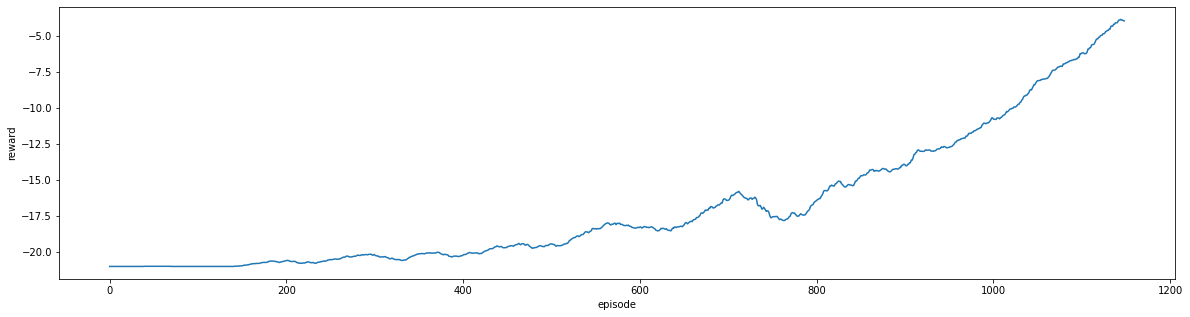

In [ ]:

ray.init()
config = DEFAULT_CONFIG.copy()
config["num_workers"] = 2
config["rollout_fragment_length"] = 50
config["train_batch_size"] = 500
config["num_envs_per_worker"] = 1
# config["framework"] = "torch"
trainer = ImpalaTrainer(config=config, env="PongNoFrameskip-v4")
# trainer = ImpalaTrainer(config=config, env="CartPole-v0")

rewards = []
for i in range(1000000):
    result = trainer.train()
    if not np.isnan(result['episode_reward_mean']):
        rewards.append(result['episode_reward_mean'])
    plot(rewards)
    # print(pretty_print(result))

    if i % 100 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
